# Nettoyage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [2]:
nom_region = "Grand_Est"
df=pd.read_csv('dpe_GE')

C:\Users\lilym\AppData\Local\Temp\ipykernel_22624\2359103114.py:2: DtypeWarning: Columns (53,86,97,156,172,173,174,175,176,177,183,189,190,191,192,193,194,196,198,199,201,203,204,208,212,220,222,223,225) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('dpe_GE')


In [3]:
df

,configuration_installation_chauffage_n1,conso_chauffage_installation_chauffage_n1,type_generateur_n1_ecs_n1,numero_voie_ban,score_ban,surface_habitable_immeuble,conso_auxiliaires_ep,deperditions_murs,cout_eclairage,conso_auxiliaires_ef,statut_geocodage,ventilation_posterieure_2012,cout_chauffage,conso_5_usages_par_m2_ep,date_etablissement_dpe,conso_ecs_ef_energie_n1,conso_ecs_ef_energie_n2,emission_ges_chauffage,description_installation_chauffage_n1,conso_5_usages_par_m2_ef,cout_ecs_energie_n2,conso_chauffage_ef_energie_n1,conso_chauffage_ef_energie_n2,qualite_isolation_menuiseries,cout_total_5_usages_energie_n2,date_reception_dpe,cout_total_5_usages_energie_n1,cout_ecs_energie_n1,qualite_isolation_plancher_bas,modele_dpe,qualite_isolation_enveloppe,conso_chauffage_generateur_n1_installation_n1,type_energie_n1,emission_ges_eclairage,type_energie_n2,code_postal_ban,emission_ges_ecs,conso_5_usages_ef_energie_n2,conso_5_usages_ef,conso_5_usages_ef_energie_n1,code_insee_ban,deperditions_planchers_bas,nombre_niveau_immeuble,conso_5_usages_ep,date_fin_validite_dpe,deperditions_enveloppe,complement_adresse_batiment,code_region_ban,volume_stockage_generateur_n1_ecs_n1,surface_chauffee_installation_chauffage_n1,version_dpe,besoin_ecs,coordonnee_cartographique_x_ban,type_generateur_chauffage_principal,type_energie_principale_ecs,apport_solaire_saison_chauffe,adresse_ban,nombre_appartement,deperditions_renouvellement_air,_rand,surface_habitable_desservie_par_installation_ecs_n1,production_electricite_pv_kwhep_par_an,type_installation_chauffage,nombre_niveau_logement,surface_habitable_logement,cout_ecs,type_installation_ecs_n1,emission_ges_5_usages_energie_n1,appartement_non_visite,emission_ges_5_usages_energie_n2,apport_interne_saison_froide,emission_ges_5_usages_par_m2,description_generateur_chauffage_n1_installation_n1,qualite_isolation_plancher_haut_comble_perdu,apport_interne_saison_chauffe,apport_solaire_saison_froide,type_generateur_n1_installation_n1,nombre_logements_desservis_par_installation_ecs_n1,complement_adresse_logement,cout_auxiliaires,type_emetteur_installation_chauffage_n1,besoin_chauffage,configuration_installation_ecs_n1,description_installation_ecs_n1,classe_inertie_batiment,deperditions_ponts_thermiques,type_generateur_chauffage_principal_ecs,emission_ges_refroidissement,hauteur_sous_plafond,conso_chauffage_ef,nom_commune_ban,_geopoint,date_visite_diagnostiqueur,type_batiment,periode_construction,type_installation_ecs,conso_ecs_ep,numero_dpe_immeuble_associe,conso_ecs_ef,emission_ges_5_usages,date_derniere_modification_dpe,etiquette_ges,identifiant_ban,deperditions_baies_vitrees,type_energie_generateur_n1_ecs_n1,ubat_w_par_m2_k,numero_etage_appartement,nom_commune_brut,conso_ef_installation_ecs_n1,etiquette_dpe,description_generateur_n1_ecs_n1,code_departement_ban,type_installation_chauffage_n1,methode_application_dpe,adresse_brut,cout_total_5_usages,conso_refroidissement_ef,conso_eclairage_ef,deperditions_planchers_hauts,zone_climatique,conso_ef_generateur_n1_ecs_n1,emission_ges_ecs_energie_n1,emission_ges_ecs_energie_n2,cout_refroidissement,conso_chauffage_ep,conso_eclairage_ep,usage_generateur_n1_installation_n1,nom_rue_ban,qualite_isolation_murs,type_installation_solaire_n1,classe_altitude,adresse_complete_brut,conso_refroidissement_ep,type_energie_principale_chauffage,numero_dpe,_i,besoin_refroidissement,emission_ges_chauffage_energie_n2,emission_ges_chauffage_energie_n1,cout_chauffage_energie_n2,deperditions_portes,cout_chauffage_energie_n1,coordonnee_cartographique_y_ban,type_energie_generateur_n1_installation_n1,code_postal_brut,emission_ges_auxiliaires,usage_generateur_n1_ecs_n1,_score,_id,provenance_id_rnb,presence_brasseur_air,isolation_toiture,id_rnb,annee_construction,protection_solaire_exterieure,logement_traversant,nom_residence,indicateur_confort_ete,inertie_lourde,qualite_isolation_plancher_haut_toit_terrasse,configuration_installation_chauffage_n2,conso_chauffage_generateur_n1_installation_n2,cons

In [4]:
def profile_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyse un DataFrame pour déterminer le type de données de chaque colonne,
    le nombre de valeurs manquantes (NaN) et le nombre de valeurs uniques.

    Args:
        df: Le DataFrame pandas à analyser.

    Returns:
        Un nouveau DataFrame contenant le profil de chaque colonne.
    """
    
    # Création d'un DataFrame vide pour stocker les résultats de l'analyse
    profile = pd.DataFrame(index=df.columns)
    
    # 1. Type des Variables (dtype)
    profile['Type de Variable'] = df.dtypes
    
    # 2. Nombre de Valeurs Manquantes (NaN)
    profile['Valeurs Manquantes (Count)'] = df.isnull().sum()
    
    # 3. Pourcentage de Valeurs Manquantes
    profile['Valeurs Manquantes (%)'] = (df.isnull().sum() / len(df)) * 100
    
    # 4. Nombre de Catégories Uniques (Cardinalité)
    profile['Nombre de Catégories Uniques'] = df.nunique()
    
    # 5. Type de Données Inférencé (Numérique, Catégorique, Date/Heure)
    def determine_data_class(series, max_unique_ratio=0.1):
        n_unique = series.nunique()
        n_rows = len(series)
        dtype = series.dtype

        # Si le type est déjà datetime
        if pd.api.types.is_datetime64_any_dtype(dtype):
            return 'Date/Heure'
        
        # Si c'est un type numérique
        if pd.api.types.is_numeric_dtype(dtype):
            # Si le nombre de valeurs uniques est inférieur à 10% de la taille, c'est probablement catégorique
            if n_unique / n_rows < max_unique_ratio and n_unique < 50:
                 return 'Numérique/Catégorique'
            return 'Numérique'
        
        # Pour les types objet (string)
        if dtype == 'object' or dtype == 'category':
            # Si peu de valeurs uniques par rapport au total, c'est catégorique
            if n_unique / n_rows < max_unique_ratio:
                return 'Catégorique'
            return 'Texte (ID/Nom)'
        
        return str(dtype) # Type par défaut

    profile['Classe Inférencée'] = df.apply(determine_data_class)
    
    return profile.sort_values(by='Nombre de Catégories Uniques', ascending=False)



In [5]:
# 2. Lancement de la fonction d'analyse
df_profil = profile_dataframe(df)

# 3. Affichage du résultat
print("="*60)
print("Analyse de Profil du DataFrame :")
print("="*60)
print(df_profil)
print("\n")

Analyse de Profil du DataFrame :
                                                   Type de Variable  \
numero_dpe                                                   object   
_id                                                          object   
_i                                                            int64   
_rand                                                         int64   
adresse_complete_brut                                        object   
...                                                             ...   
modele_dpe                                                   object   
conso_ef_generateur_n2_ecs_n1                               float64   
usage_generateur_n2_ecs_n1                                   object   
facteur_couverture_solaire_saisi_installation_c...          float64   
_score                                                      float64   

                                                    Valeurs Manquantes (Count)  \
numero_dpe                      

C:\Users\lilym\AppData\Local\Temp\ipykernel_22624\1884368819.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


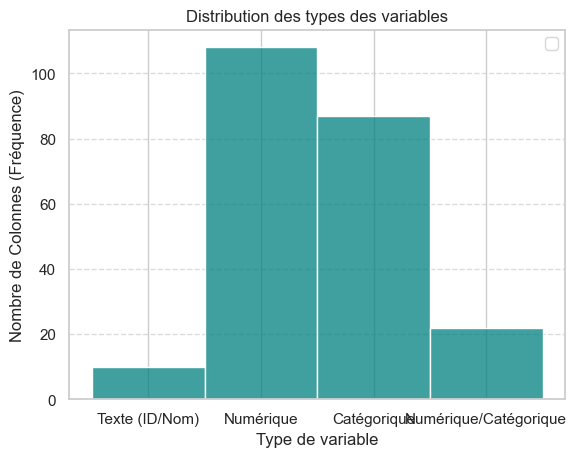

In [6]:
sns.histplot(df_profil['Classe Inférencée'], bins=20, color='teal')

plt.title('Distribution des types des variables')
plt.xlabel('Type de variable')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

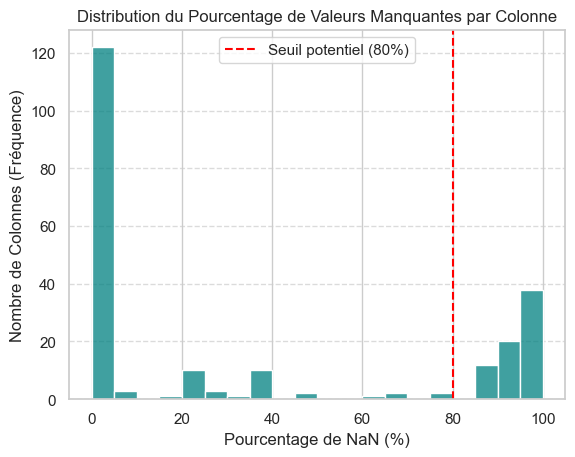

In [7]:
sns.histplot(df_profil['Valeurs Manquantes (%)'], bins=20,  color='teal')
SEUIL_VISUEL = 80
plt.axvline(SEUIL_VISUEL, color='red', linestyle='--', label=f'Seuil potentiel ({SEUIL_VISUEL}%)')

plt.title('Distribution du Pourcentage de Valeurs Manquantes par Colonne')
plt.xlabel('Pourcentage de NaN (%)')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [8]:
#Retirer les colonnes où il manque le plus de valeurs

lst=df_profil[df_profil['Valeurs Manquantes (%)']>78].index.values.tolist()
print(len(lst))

df_clean1=df.copy().drop(columns=lst)

df_clean1

70


,configuration_installation_chauffage_n1,conso_chauffage_installation_chauffage_n1,type_generateur_n1_ecs_n1,numero_voie_ban,score_ban,surface_habitable_immeuble,conso_auxiliaires_ep,deperditions_murs,cout_eclairage,conso_auxiliaires_ef,statut_geocodage,ventilation_posterieure_2012,cout_chauffage,conso_5_usages_par_m2_ep,date_etablissement_dpe,conso_ecs_ef_energie_n1,conso_ecs_ef_energie_n2,emission_ges_chauffage,description_installation_chauffage_n1,conso_5_usages_par_m2_ef,cout_ecs_energie_n2,conso_chauffage_ef_energie_n1,conso_chauffage_ef_energie_n2,qualite_isolation_menuiseries,cout_total_5_usages_energie_n2,date_reception_dpe,cout_total_5_usages_energie_n1,cout_ecs_energie_n1,qualite_isolation_plancher_bas,modele_dpe,qualite_isolation_enveloppe,conso_chauffage_generateur_n1_installation_n1,type_energie_n1,emission_ges_eclairage,type_energie_n2,code_postal_ban,emission_ges_ecs,conso_5_usages_ef_energie_n2,conso_5_usages_ef,conso_5_usages_ef_energie_n1,code_insee_ban,deperditions_planchers_bas,nombre_niveau_immeuble,conso_5_usages_ep,date_fin_validite_dpe,deperditions_enveloppe,complement_adresse_batiment,code_region_ban,volume_stockage_generateur_n1_ecs_n1,surface_chauffee_installation_chauffage_n1,version_dpe,besoin_ecs,coordonnee_cartographique_x_ban,type_energie_principale_ecs,apport_solaire_saison_chauffe,adresse_ban,nombre_appartement,deperditions_renouvellement_air,_rand,surface_habitable_desservie_par_installation_ecs_n1,production_electricite_pv_kwhep_par_an,type_installation_chauffage,nombre_niveau_logement,surface_habitable_logement,cout_ecs,type_installation_ecs_n1,emission_ges_5_usages_energie_n1,appartement_non_visite,emission_ges_5_usages_energie_n2,apport_interne_saison_froide,emission_ges_5_usages_par_m2,description_generateur_chauffage_n1_installation_n1,qualite_isolation_plancher_haut_comble_perdu,apport_interne_saison_chauffe,apport_solaire_saison_froide,type_generateur_n1_installation_n1,nombre_logements_desservis_par_installation_ecs_n1,complement_adresse_logement,cout_auxiliaires,type_emetteur_installation_chauffage_n1,besoin_chauffage,configuration_installation_ecs_n1,description_installation_ecs_n1,classe_inertie_batiment,deperditions_ponts_thermiques,emission_ges_refroidissement,hauteur_sous_plafond,conso_chauffage_ef,nom_commune_ban,_geopoint,date_visite_diagnostiqueur,type_batiment,periode_construction,type_installation_ecs,conso_ecs_ep,numero_dpe_immeuble_associe,conso_ecs_ef,emission_ges_5_usages,date_derniere_modification_dpe,etiquette_ges,identifiant_ban,deperditions_baies_vitrees,type_energie_generateur_n1_ecs_n1,ubat_w_par_m2_k,numero_etage_appartement,nom_commune_brut,conso_ef_installation_ecs_n1,etiquette_dpe,description_generateur_n1_ecs_n1,code_departement_ban,type_installation_chauffage_n1,methode_application_dpe,adresse_brut,cout_total_5_usages,conso_refroidissement_ef,conso_eclairage_ef,deperditions_planchers_hauts,zone_climatique,conso_ef_generateur_n1_ecs_n1,emission_ges_ecs_energie_n1,emission_ges_ecs_energie_n2,cout_refroidissement,conso_chauffage_ep,conso_eclairage_ep,usage_generateur_n1_installation_n1,nom_rue_ban,qualite_isolation_murs,type_installation_solaire_n1,classe_altitude,adresse_complete_brut,conso_refroidissement_ep,type_energie_principale_chauffage,numero_dpe,_i,besoin_refroidissement,emission_ges_chauffage_energie_n2,emission_ges_chauffage_energie_n1,cout_chauffage_energie_n2,deperditions_portes,cout_chauffage_energie_n1,coordonnee_cartographique_y_ban,type_energie_generateur_n1_installation_n1,code_postal_brut,emission_ges_auxiliaires,usage_generateur_n1_ecs_n1,_id,provenance_id_rnb,presence_brasseur_air,isolation_toiture,id_rnb,annee_construction,protection_solaire_exterieure,logement_traversant,indicateur_confort_ete,inertie_lourde,qualite_isolation_plancher_haut_toit_terrasse,categorie_enr
0,Installation de chauffage simple,145057.0,Chaudière gaz à condensation après 2015,38,0.67,1500.7,319.2,522.4,11.6,138.8,adresse géocodée ban à l'adresse,0,142.0,258.6,2025

In [9]:
#Supprimer les noms de colonnes à plus de 80% de valeurs manquantes dans df_profil

df_profil=df_profil.drop(lst)

df_profil


,Type de Variable,Valeurs Manquantes (Count),Valeurs Manquantes (%),Nombre de Catégories Uniques,Classe Inférencée
numero_dpe,object,0,0.000000,1151000,Texte (ID/Nom)
_id,object,0,0.000000,1151000,Texte (ID/Nom)
_i,int64,0,0.000000,1151000,Numérique
_rand,int64,0,0.000000,683665,Numérique
adresse_complete_brut,object,0,0.000000,563313,Texte (ID/Nom)
...,...,...,...,...,...
presence_brasseur_air,float64,435407,37.828584,2,Numérique/Catégorique
provenance_id_rnb,object,455988,39.616681,2,Catégorique
inertie_lourde,float64,448218,38.941616,2,Numérique/Catégorique
code_region_ban,int64,0,0.000000,1,Numérique/Catégorique


C:\Users\lilym\AppData\Local\Temp\ipykernel_22624\2022057862.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


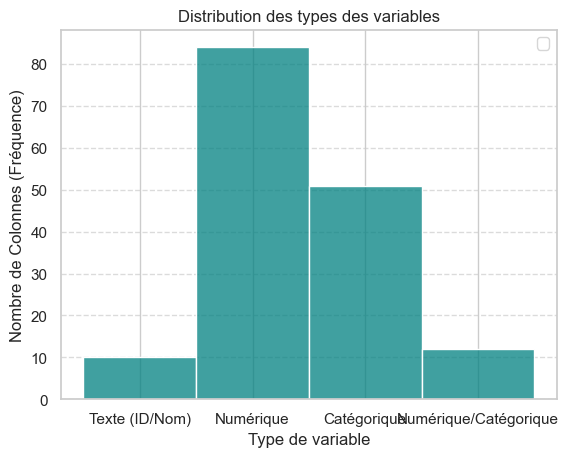

In [10]:
sns.histplot(df_profil['Classe Inférencée'], bins=30, color='teal')

plt.title('Distribution des types des variables')
plt.xlabel('Type de variable')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [11]:
def analyze_nan_by_row(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule le nombre et le pourcentage de NaN pour chaque ligne d'un DataFrame.

    Args:
        df: Le DataFrame pandas à analyser.

    Returns:
        Le DataFrame original avec deux nouvelles colonnes d'analyse.
    """
    

    # 1. Calcul du nombre de NaN par ligne
    df['nan_count_ligne'] = df.isnull().sum(axis=1)

    # 2. Calcul du pourcentage de NaN par ligne
    df['nan_pourcentage_ligne'] = (df['nan_count_ligne'] / (len(df.columns) - 1)) * 100

    return df

In [12]:
df_clean2=analyze_nan_by_row(df_clean1.copy())

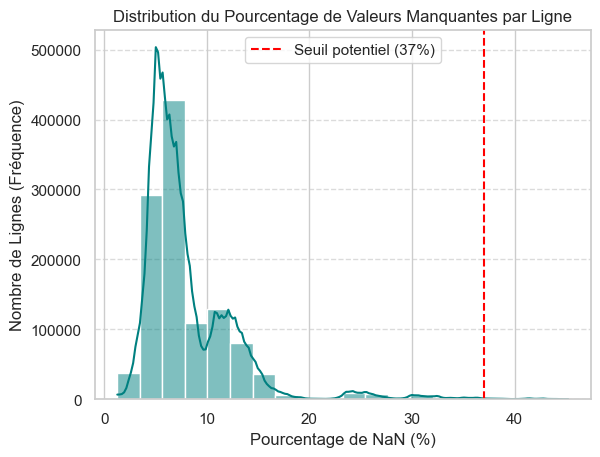

In [13]:
sns.histplot(df_clean2['nan_pourcentage_ligne'], bins=20, kde=True, color='teal')
SEUIL_VISUEL = 37
plt.axvline(SEUIL_VISUEL, color='red', linestyle='--', label=f'Seuil potentiel ({SEUIL_VISUEL}%)')

plt.title('Distribution du Pourcentage de Valeurs Manquantes par Ligne')
plt.xlabel('Pourcentage de NaN (%)')
plt.ylabel('Nombre de Lignes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [14]:
def drop_rows_by_na_threshold(df: pd.DataFrame, threshold_percent) -> pd.DataFrame:
    """
    Supprime les lignes d'un DataFrame dont le pourcentage de valeurs 
    manquantes (NaN) est supérieur ou égal au seuil spécifié.

    Args:
        df: Le DataFrame pandas à nettoyer.
        threshold_percent: Le seuil de NaN à ne pas dépasser (en pourcentage, ex: 30 pour 30%).

    Returns:
        Un nouveau DataFrame nettoyé.
    """
    
    # 1. Calculer le nombre minimal de valeurs NON-MANQUANTES (valides)
    # Le seuil est appliqué au nombre de valeurs présentes, pas au nombre de NaN.
    
    # Calculer le ratio de valeurs NON-manquantes
    valid_ratio = 1 - (threshold_percent / 100)
    
    # Calculer le nombre minimum de valeurs non-NaN requises par ligne
    min_valid_count = int(np.floor(len(df.columns) * valid_ratio))
    
    # Si le seuil est 0, on garde tout le monde (sauf si on enlève les lignes vides)
    if threshold_percent == 100:
        min_valid_count = 1 # Garde toute ligne qui a au moins 1 valeur non-NaN

    print(f"Nombre total de colonnes : {len(df.columns)}")
    print(f"Seuil de NaN max autorisé : {threshold_percent}%")
    print(f"Nombre MINIMAL de valeurs valides requises par ligne : {min_valid_count}")
    
    # 2. Appliquer la suppression avec .dropna(thresh=...)
    # On crée une copie pour ne pas modifier le DataFrame original passé en argument
    df_cleaned = df.copy().dropna(axis=0, thresh=min_valid_count)
    
    lignes_supprimees = len(df) - len(df_cleaned)
    print(f"Lignes supprimées : {lignes_supprimees} (soit {lignes_supprimees/len(df)*100:.2f}%)")
    
    return df_cleaned

In [15]:
df_clean3 = drop_rows_by_na_threshold(df_clean2,37)

Nombre total de colonnes : 159
Seuil de NaN max autorisé : 37%
Nombre MINIMAL de valeurs valides requises par ligne : 100
Lignes supprimées : 1495 (soit 0.13%)


In [16]:
def drop_nan_columns(df, threshold, use_percentage=True):
    """
    Supprime les colonnes ayant trop de valeurs manquantes (NaN).
    
    Args:
        df (pd.DataFrame): Ton DataFrame.
        threshold (float): Le seuil de tolérance. 
        use_percentage (bool): Si True, le seuil est un ratio (ex: 0.5 pour 50%).
                               Si False, le seuil est le nombre maximum de NaN autorisés.
    
    Returns:
        pd.DataFrame: Le DataFrame nettoyé.
    """
    if use_percentage:
        # On calcule le ratio de NaN par colonne
        nan_ratio = df.isna().mean()
        cols_to_drop = nan_ratio[nan_ratio > threshold].index
    else:
        # On compte le nombre brut de NaN
        nan_count = df.isna().sum()
        cols_to_drop = nan_count[nan_count > threshold].index
    
    print(f"Colonnes supprimées : {list(cols_to_drop)}")
    return df.drop(columns=cols_to_drop)

In [17]:
df_clean_final = drop_nan_columns(df_clean3.copy(),70)

Colonnes supprimées : []


## 2. Préparation et Nettoyage des Données

Pour prédire la **consommation électrique théorique (Énergie Primaire)**, nous allons :
1.  **Filtrer** les logements dont l'énergie principale de chauffage est l'électricité.
2.  **Créer des variables simplifiées** compréhensibles par l'utilisateur (ex: Type de chauffage simplifié).
3.  **Sélectionner** les variables explicatives (features) pertinentes.
4.  **Nettoyer** les valeurs manquantes et aberrantes.

In [18]:
# 1. Simplification du type de chauffage
def simplifier_chauffage(val):
    if pd.isna(val):
        return 'Autre/Inconnu'
    val = str(val).lower()
    if 'pac' in val or 'pompe' in val or 'thermodynamique' in val:
        return 'Pompe à Chaleur (PAC)'
    elif 'radiateur' in val or 'convecteur' in val or 'panneau' in val or 'rayonnant' in val or 'standard' in val:
        return 'Radiateur Électrique (Effet Joule)'
    elif 'chaudière' in val:
        return 'Chaudière Électrique'
    else:
        return 'Autre Élec'


if not df_clean_final.empty:
    # Filtrage pour l'électricité
    # Note: On vérifie si la colonne existe, car le nom peut varier légèrement selon les versions du CSV
    if 'type_energie_principale_chauffage' in df.columns:
        df_elec = df_clean_final[df_clean_final['type_energie_principale_chauffage'] == 'Électricité'].copy()
    else:
        print("Attention : Colonne 'type_energie_principale_chauffage' introuvable. Utilisation du dataset complet (risqué).")
        df_elec = df_clean_final.copy()
        
    print(f"Nombre de logements sélectionnés (Chauffage Élec) : {df_elec.shape[0]}")

    # --- Création de features simplifiées ---


    if 'type_generateur_chauffage_principal' in df_elec.columns:
        df_elec['chauffage_simplifie'] = df_elec['type_generateur_chauffage_principal'].apply(simplifier_chauffage)
    else:
        df_elec['chauffage_simplifie'] = 'Inconnu'

    # 2. Logement Traversant
    if 'logement_traversant' in df_elec.columns:
        df_elec['logement_traversant_clean'] = df_elec['logement_traversant'].map({1.0: 'Oui', 0.0: 'Non'}).fillna('Inconnu')
    else:
         df_elec['logement_traversant_clean'] = 'Inconnu'

    # 3. Isolation Toiture
    if 'isolation_toiture' in df_elec.columns:
        df_elec['isolation_toiture_clean'] = df_elec['isolation_toiture'].map({1.0: 'Isolé', 0.0: 'Non Isolé'}).fillna('Inconnu')
    else:
        df_elec['isolation_toiture_clean'] = 'Inconnu'


    # Sélection des features (X) et de la target (y)
    target_col = 'conso_5_usages_ep' # Updated to Primary Energy

    # Liste enrichie de variables "connues de l'utilisateur"
    features_num = [
        'surface_habitable_logement',
        'annee_construction', 
        'hauteur_sous_plafond'
    ]

    features_cat = [
        'type_batiment', 
        'zone_climatique', 
        'classe_altitude',
        'chauffage_simplifie',        
        'logement_traversant_clean',  
        'isolation_toiture_clean'     
    ]
    
    # Filtrer uniquement les colonnes présentes
    features_num = [c for c in features_num if c in df_elec.columns]
    features_cat = [c for c in features_cat if c in df_elec.columns]

    print("Variables numériques utilisées :", features_num)
    print("Variables catégorielles utilisées :", features_cat)

    # Création du dataset final
    available_cols = features_num + features_cat
    X = df_elec[available_cols]
    
    if target_col in df_elec.columns:
        y = df_elec[target_col]
        # Nettoyage rapide des cibles aberrantes
        mask = (y > 0) & (y < 100000)
        X = X[mask]
        y = y[mask]
        print(f"Données après nettoyage target : {X.shape[0]}")
    else:
        print(f"ERREUR : La colonne cible '{target_col}' est introuvable.")
        y = pd.Series()

Nombre de logements sélectionnés (Chauffage Élec) : 287834
Variables numériques utilisées : ['surface_habitable_logement', 'annee_construction', 'hauteur_sous_plafond']
Variables catégorielles utilisées : ['type_batiment', 'zone_climatique', 'classe_altitude', 'chauffage_simplifie', 'logement_traversant_clean', 'isolation_toiture_clean']
Données après nettoyage target : 284557


In [19]:
print(df_elec.columns.tolist())

['configuration_installation_chauffage_n1', 'conso_chauffage_installation_chauffage_n1', 'type_generateur_n1_ecs_n1', 'numero_voie_ban', 'score_ban', 'surface_habitable_immeuble', 'conso_auxiliaires_ep', 'deperditions_murs', 'cout_eclairage', 'conso_auxiliaires_ef', 'statut_geocodage', 'ventilation_posterieure_2012', 'cout_chauffage', 'conso_5_usages_par_m2_ep', 'date_etablissement_dpe', 'conso_ecs_ef_energie_n1', 'conso_ecs_ef_energie_n2', 'emission_ges_chauffage', 'description_installation_chauffage_n1', 'conso_5_usages_par_m2_ef', 'cout_ecs_energie_n2', 'conso_chauffage_ef_energie_n1', 'conso_chauffage_ef_energie_n2', 'qualite_isolation_menuiseries', 'cout_total_5_usages_energie_n2', 'date_reception_dpe', 'cout_total_5_usages_energie_n1', 'cout_ecs_energie_n1', 'qualite_isolation_plancher_bas', 'modele_dpe', 'qualite_isolation_enveloppe', 'conso_chauffage_generateur_n1_installation_n1', 'type_energie_n1', 'emission_ges_eclairage', 'type_energie_n2', 'code_postal_ban', 'emission_ges_

In [20]:
X

,surface_habitable_logement,annee_construction,hauteur_sous_plafond,type_batiment,zone_climatique,classe_altitude,chauffage_simplifie,logement_traversant_clean,isolation_toiture_clean
1,33.0,1950.0,2.5,appartement,H1b,inférieur à 400m,Inconnu,Oui,Non Isolé
2,32.4,NaN,2.3,appartement,H1b,inférieur à 400m,Inconnu,Oui,Isolé
3,18.8,NaN,2.7,appartement,H1b,inférieur à 400m,Inconnu,Inconnu,Inconnu
4,29.0,1979.0,2.5,appartement,H1b,inférieur à 400m,Inconnu,Oui,Isolé
5,86.0,NaN,2.5,maison,H1b,inférieur à 400m,Inconnu,Oui,Isolé
...,...,...,...,...,...,...,...,...,...
1150918,140.0,1840.0,2.5,maison,H1b,inférieur à 400m,Inconnu,Oui,Isolé
1150921,68.0,NaN,2.3,appartement,H1b,400-800m,Inconnu,Oui,Isolé
1150922,66.0,1978.0,2.5,appartement,H1b,inférieur à 400m,Inconnu,Inconnu,Inconnu
1150953,53.0,1989.0,2.5,maison,H1b,400-800m,Inconnu,Oui,Isolé


In [21]:
y

1           7817.0
2           7888.5
3           5367.3
4           8336.7
5          23350.5
            ...   
1150918    23898.5
1150921    14642.1
1150922     8751.9
1150953    13516.5
1150958     7466.6
Name: conso_5_usages_ep, Length: 284557, dtype: float64

In [22]:
# On utilise les noms de colonnes que vous venez de créer/nettoyer
features_cat = [
    'type_batiment', 
    'zone_climatique', 
    'classe_altitude',
    'chauffage_simplifie',        
    'logement_traversant_clean',  
    'isolation_toiture_clean',
    'qualite_isolation_enveloppe',
    'periode_construction',
    'qualite_isolation_murs',
    'qualite_isolation_menuiseries',
    'qualite_isolation_plancher_bas',
    'type_emetteur_installation_chauffage_n1',
    'type_installation_ecs',
    'type_generateur_n1_ecs_n1',
    'presence_brasseur_air',
    'protection_solaire_exterieure',
]

features_num = [
    'surface_habitable_logement',
    'annee_construction', 
    'hauteur_sous_plafond',
    'ubat_w_par_m2_k',
    'besoin_chauffage',
    'apport_solaire_saison_chauffe'
]

target = 'conso_5_usages_ep'



In [23]:
def entrainer_region(df):
    # 1. Filtrer pour la tranche
    data = df.copy()
    
    data = data.dropna(subset=[target]) 
    data = data[np.isfinite(data[target])] 
    data = data[data[target] > 0]

    if len(data) < 50: # Sécurité : pas de modèle si trop peu de données
        return None
    
    X = data[features_cat + features_num]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 2. Prétraitement (Le OneHotEncoder va créer toutes les colonnes manquantes)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features_num),
            ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat)
        ]
    )
    
    # 3. Le Pipeline XGBoost
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6))
    ])
    
    # 4. Entraînement
    pipeline.fit(X_train, y_train)
    
    # 5. Score
    score = r2_score(y_test, pipeline.predict(X_test))
    
    return {'model': pipeline, 'r2': score}

In [24]:
resultat = entrainer_region(df_elec)
resultat
    

{'model': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['surface_habitable_logement',
                                                    'annee_construction',
                                                    'hauteur_sous_plafond',
                                                    'ubat_w_par_m2_k',
                                                    'besoin_chauffage',
                                                    'apport_solaire_saison_chauffe']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['type_batiment',
                                                    'zone_climatique',
                                                    'classe_altitude',
                                                    'chauff

In [25]:
nom_fichier = f"{nom_region}/V2/pipeline_{nom_region}.pkl"
with open(nom_fichier, 'wb') as f:
    pickle.dump(resultat['model'], f)
print(f"✅ Sauvegardé : {nom_fichier}")


✅ Sauvegardé : Grand_Est/V2/pipeline_Grand_Est.pkl


## 4. Analyse des Résultats et Importance des Variables

Regardons quel modèle est le plus performant et quelles variables pèsent le plus dans la prédiction.